# Transfer Learning with TensorFlow Part2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.


In [ ]:
# Check if we are using a GPU
!nvdia-smi

/bin/bash: nvdia-smi: command not found


## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks or elsewhere.

We've done this for some of the functions we've used previously here: https://github.com/JoachimLombardi/Helper_functions.git

In [ ]:
!git clone https://github.com/JoachimLombardi/Helper_functions.git
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

Cloning into 'Helper_functions'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), 13.89 KiB | 1.74 MiB/s, done.


In [ ]:
# import helper functions we're going to use in this notebook
from Helper_functions.course_ztm import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you are running this notebook in Google Colab, when it times out Colab will delete `Helper_functions.py`, so you'have to redownload it if you want access to your helper functions.

## Let's get some data 

This time we're going to see how we can uses the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food). 

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-05-07 08:10:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  61.8MB/s    in 2.6s    

2023-05-07 08:10:36 (61.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent") 

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
# Create training and test directories paths

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# No need to create an image data generator
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)   

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out classnames of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of dataset 
for images, labels in train_data_10_percent.take(1): # Unbatch it
  print(images, labels)

tf.Tensor(
[[[[1.00000000e+01 2.00000000e+00 2.29591817e-01]
   [9.38265324e+00 4.38265276e+00 1.38265300e+00]
   [9.14285755e+00 4.14285755e+00 1.28571439e+00]
   ...
   [1.90943619e+02 1.81515091e+02 1.76300827e+02]
   [1.88658356e+02 1.85137970e+02 1.80469604e+02]
   [2.14219498e+02 2.14760345e+02 2.08989929e+02]]

  [[1.14744911e+01 6.47449112e+00 3.47449064e+00]
   [9.85714340e+00 4.85714340e+00 1.85714340e+00]
   [1.06581631e+01 6.08673429e+00 2.65816259e+00]
   ...
   [1.95719299e+02 1.86290771e+02 1.81474426e+02]
   [1.94459305e+02 1.91602188e+02 1.86602188e+02]
   [2.19571747e+02 2.20571747e+02 2.15571747e+02]]

  [[8.98979568e+00 4.20408154e+00 1.20408154e+00]
   [9.00000000e+00 4.21428585e+00 1.21428585e+00]
   [9.61734676e+00 5.83163261e+00 2.40306091e+00]
   ...
   [1.88494949e+02 1.78494949e+02 1.77663345e+02]
   [1.97372437e+02 1.92459229e+02 1.90015335e+02]
   [1.99775558e+02 1.99132736e+02 1.97132736e+02]]

  ...

  [[1.00000000e+00 3.00000000e+00 0.00000000e+00]
   [1

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional?hl=fr

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pooling 2D: {x.shape}")

# 7. Create the output activations layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[create_tensorboard_callback("transfer_learning",
                                                             "10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Epoch 1/5
24/24 [==============================] - 330s 14s/step - loss: 1.8649 - accuracy: 0.4307 - val_loss: 1.2989 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 271s 12s/step - loss: 1.0811 - accuracy: 0.7707 - val_loss: 0.8621 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 262s 11s/step - loss: 0.7761 - accuracy: 0.8307 - val_loss: 0.6911 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 261s 11s/step - loss: 0.6303 - accuracy: 0.8653 - val_loss: 0.6057 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 263s 11s/step - loss: 0.5339 - accuracy: 0.8920 - val_loss: 0.5522 - val_accuracy: 0.8644


In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 rescaling_1
2 normalization_1
3 rescaling_2
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
len(base_model.layers)

238

In [ ]:
# How about we get a summary of the base model ?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [ ]:
# How about a summary of our whole model ?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


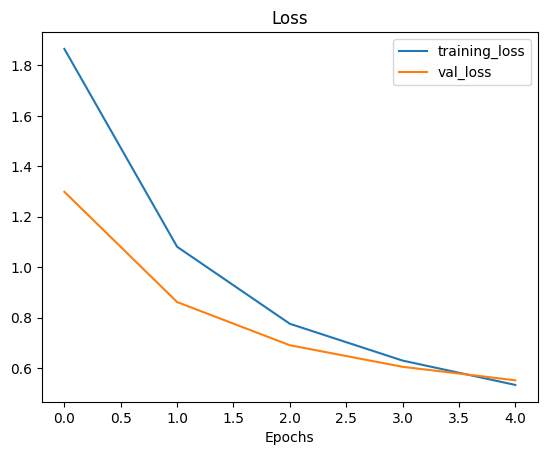

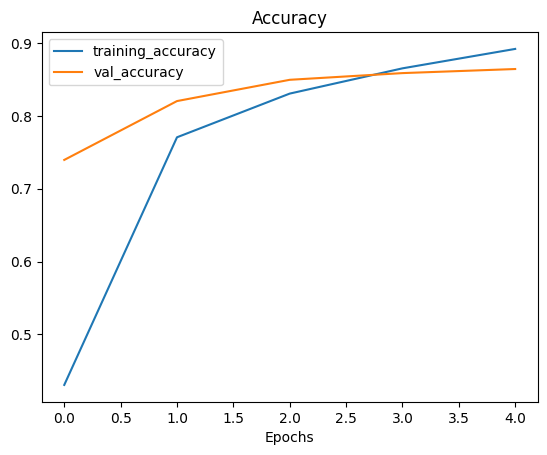

In [ ]:
# Check out our loss curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape 
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]



In [ ]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> 🛠 **Patrice:** Try to do the same with the above two cells but this this time use `GlobalMaxPool2D`... and see what happens.

In [ ]:
# Pass the random tensor through a global average pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, (in our case, this is the output of the `tf.keras.layers.GlobalAveragePool2D()` layer) which can then be used to extract patterns out of for our own specific problem. 

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out: 

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> 🔑 **Note:** Thoughout all experiments the same test dataset will be used to evaluate our model... This ensure consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-05-07 08:11:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.16.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   113MB/s    in 1.1s    

2023-05-07 08:11:31 (113 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# How many images are we working with ?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [ ]:
# Setup dataloaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model 

To add data augmentation right into the models, we can use the layers inside: 

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are: 
* Preprocessing of images (augmenting them) happens n the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere. 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms, etc...
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1/255.) # Keep for models like ResNet50V2 but Efficient'sNet have rescaling built-in.
], name="data_augmentation")

### Visualize our data augmentation layer

(-0.5, 412.5, 539.5, -0.5)

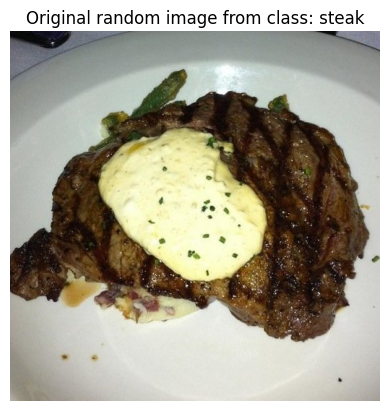

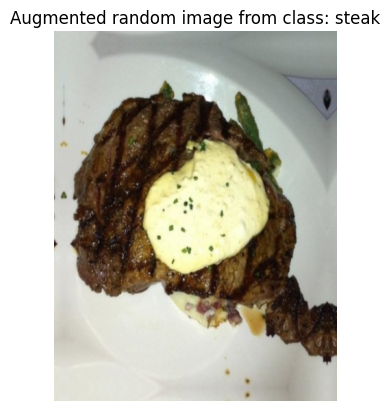

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False);

# Now let's plot our augmented random image
augmented_image = data_augmentation(img)/255.
plt.figure()
plt.imshow(augmented_image)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% percent of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
# layers take in the right side
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it, keep it to inference mode, this also insures batchnorm layers don't get updated even after we unfreeze in fine tuning - https://keras.io/guides/transfer_learning/#build-a-model
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and the outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# Fit the model and save its history
history_1_percent = model_1.fit(train_data_1_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_1_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[create_tensorboard_callback("transfer_learning",
                                                             "1_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction/20230506-100537
Epoch 1/5
3/3 [==============================] - 53s 22s/step - loss: 2.4812 - accuracy: 0.1000 - val_loss: 2.2080 - val_accuracy: 0.2220
Epoch 2/5
3/3 [==============================] - 35s 16s/step - loss: 2.1852 - accuracy: 0.2857 - val_loss: 2.1033 - val_accuracy: 0.2993
Epoch 3/5
3/3 [==============================] - 46s 22s/step - loss: 1.9728 - accuracy: 0.4286 - val_loss: 1.9931 - val_accuracy: 0.3586
Epoch 4/5
3/3 [==============================] - 48s 23s/step - loss: 1.8484 - accuracy: 0.4000 - val_loss: 1.9059 - val_accuracy: 0.4112
Epoch 5/5
3/3 [==============================] - 44s 21s/step - loss: 1.6430 - accuracy: 0.5857 - val_loss: 1.8149 - val_accuracy: 0.4408


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 126s 2s/step - loss: 1.7868 - accuracy: 0.4664


[1.7868376970291138, 0.46639999747276306]

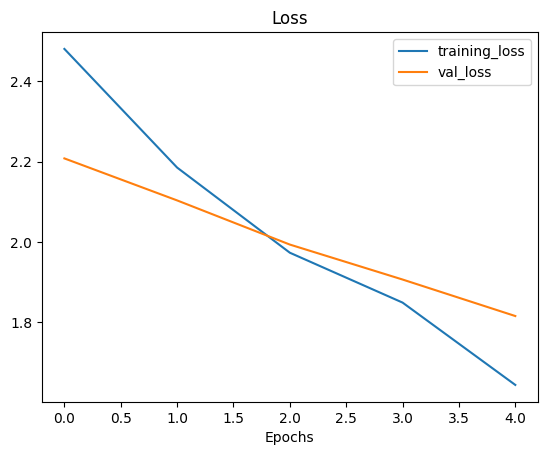

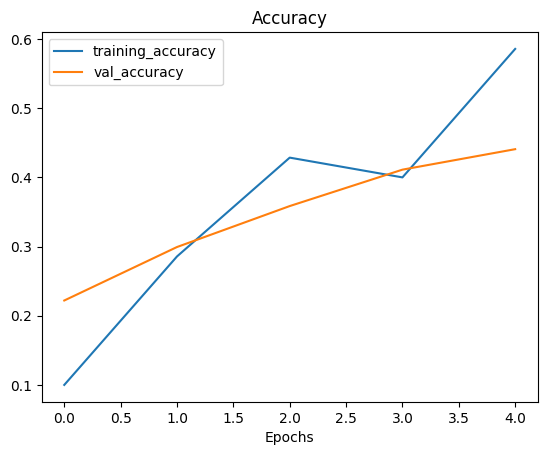

In [ ]:
# How do the model with 1 percent of the data augmentation loss curves look ?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Same as model_1 but with 10 percent of the data
history_10_percent = model_1.fit(train_data_10_percent,
                     epochs=5,
                     steps_per_epoch=len(train_data_10_percent),
                     validation_data=test_data,
                     validation_steps=int(0.25 * len(test_data)),
                     callbacks=[create_tensorboard_callback("transfer_learning",
                                                            "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230506-101607
Epoch 1/5
24/24 [==============================] - 98s 4s/step - loss: 1.6106 - accuracy: 0.5333 - val_loss: 1.1427 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 81s 3s/step - loss: 1.1397 - accuracy: 0.7227 - val_loss: 0.8392 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 77s 3s/step - loss: 0.8967 - accuracy: 0.7747 - val_loss: 0.7087 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 84s 4s/step - loss: 0.7531 - accuracy: 0.8293 - val_loss: 0.6190 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 79s 3s/step - loss: 0.6901 - accuracy: 0.8293 - val_loss: 0.5599 - val_accuracy: 0.8586


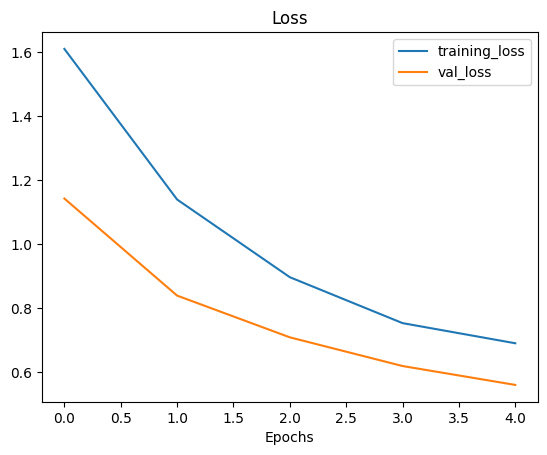

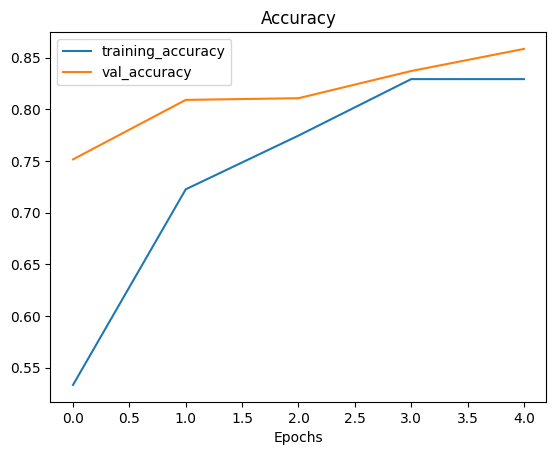

In [ ]:
# How do the model with 1 percent of the data augmentation loss curves look ?
plot_loss_curves(history_10_percent)

### Creating a ModelCheckpoint callback

The model checkpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off. 

In [ ]:
from keras.saving.saving_lib import save_weights_only

In [ ]:
checkpoint_path='drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [ ]:
def create_checkpoint(checkpoint_path=checkpoint_path):
  # Create a ModelCheckpoint callback that saves the model's weights only
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=False,
                                                          save_freq="epoch", # Save every epoch
                                                          verbose=1)
  return checkpoint_callback

In [ ]:
# Setup input shape and base model, freezing the base model layers
# layers take in the right side
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it, keep it to inference mode, this also insures batchnorm layers don't get updated even after we unfreeze in fine tuning - https://keras.io/guides/transfer_learning/#build-a-model
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and the outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Fit with checkpoint
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                     epochs=5,
                     steps_per_epoch=len(train_data_10_percent),
                     validation_data=test_data,
                     validation_steps=int(0.25 * len(test_data)),
                     callbacks=[create_tensorboard_callback("transfer_learning",
                                                            "10_percent_feature_extraction"),
                                create_checkpoint()])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230507-114801
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9480
Epoch 1: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 85s 4s/step - loss: 0.1449 - accuracy: 0.9480 - val_loss: 0.2498 - val_accuracy: 0.9243
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9720
Epoch 2: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 97s 4s/step - loss: 0.0826 - accuracy: 0.9720 - val_loss: 0.3312 - val_accuracy: 0.9013
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9733
Epoch 3: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] 

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 117s 1s/step - loss: 0.6232 - accuracy: 0.8392


[0.62322998046875, 0.8392000198364258]

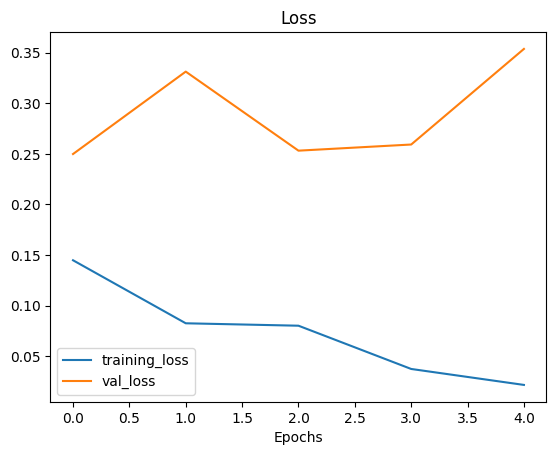

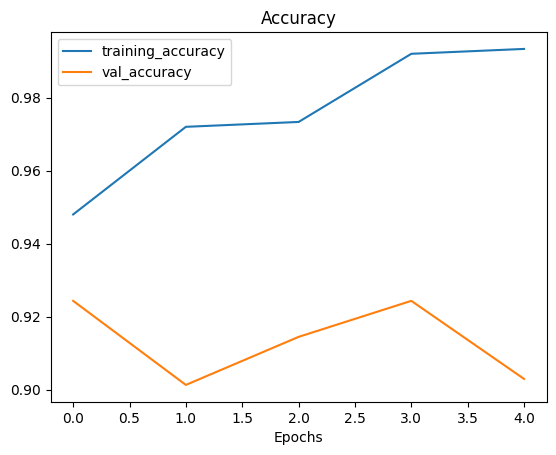

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weigths
Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 130s 2s/step - loss: 0.6232 - accuracy: 0.8392


In [ ]:
# If the result from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results 
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model_3: Fine-tuning an existing model on 10% of data 

> 🔑 **Note:** Fine-tuning usually works best **after** training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are this layers trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f5f515e57e0> True
<keras.engine.sequential.Sequential object at 0x7f5f5167bf10> True
<keras.engine.functional.Functional object at 0x7f5f43c4cd90> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f5f43b3dd20> True
<keras.layers.core.dense.Dense object at 0x7f5f43b0e6e0> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable ?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# How many trainable variables are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers until the last 10.
for layer in base_model.layers[:-10]:
  layer.trainable = False

print(len(model_2.layers[2].trainable_variables))

10


In [ ]:
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate for fine-tuning by 10x
                metrics=["accuracy"])

> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much ? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the UMLFiT paper: [learning rate tuning](https://arxiv.org/abs/1801.06146) 

In [ ]:
# Check which layers are tunable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there ?
print(len(model_2.trainable_variables)) 

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
initial_epoch = 5

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], #je recalcule la dernière époque
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                                      experiment_name="10_percent_fine_tune_last_10")]) #Start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230507-082805
Epoch 5/10
24/24 [==============================] - 100s 4s/step - loss: 0.7188 - accuracy: 0.7827 - val_loss: 0.5932 - val_accuracy: 0.7796
Epoch 6/10
24/24 [==============================] - 82s 4s/step - loss: 0.3330 - accuracy: 0.8960 - val_loss: 0.5214 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 81s 3s/step - loss: 0.1834 - accuracy: 0.9373 - val_loss: 0.4746 - val_accuracy: 0.8421
Epoch 8/10
24/24 [==============================] - 70s 3s/step - loss: 0.1722 - accuracy: 0.9440 - val_loss: 0.5180 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 78s 3s/step - loss: 0.1378 - accuracy: 0.9600 - val_loss: 0.4257 - val_accuracy: 0.8717
Epoch 10/10
24/24 [==============================] - 91s 4s/step - loss: 0.0683 - accuracy: 0.9813 - val_loss: 0.4758 - val_accuracy: 0.8635


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epochs).
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 149s 2s/step - loss: 0.4868 - accuracy: 0.8556


In [ ]:
results_10_percent_data_aug

[0.62322998046875, 0.8392000198364258]

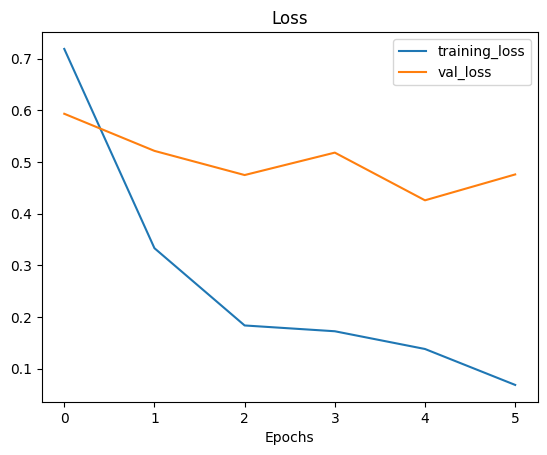

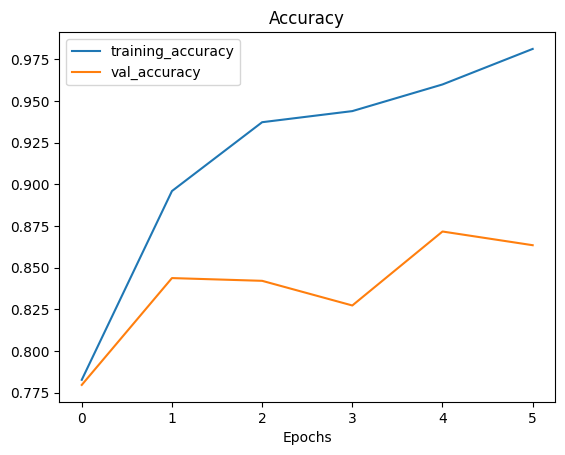

In [ ]:
# Check-out the lost curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning). 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epoch=5):
  """
  Compare two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Plot the two figures
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label="Start Fine Tuning") # x va de 4 à 4 et y se limite aux autres valeurs de y.
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label="Start Fine Tuning") # x va de 4 à 4 et y se limite aux autres valeurs de y.
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

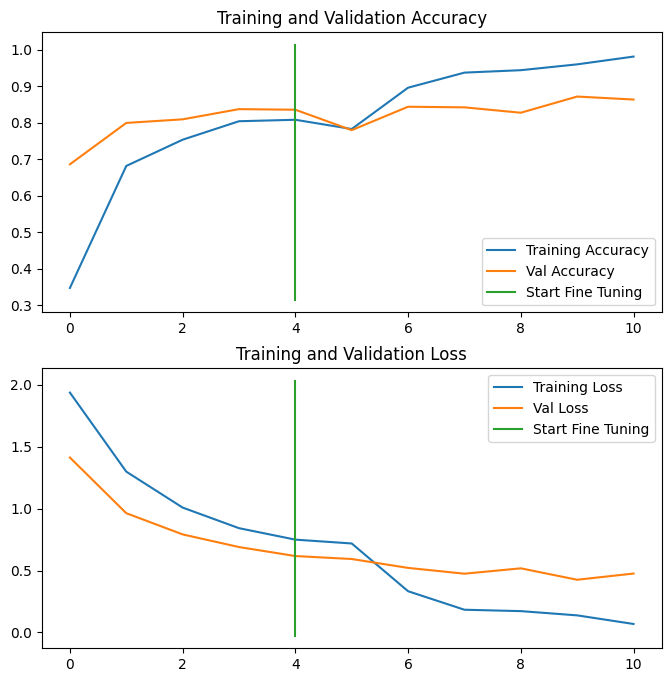

In [ ]:
compare_histories(history_10_percent_data_aug, 
                  history_fine_10_percent_data_aug,
                  initial_epoch=5)

Lorsque l'on additionne les courbes, de [0] à [4] puis de [4] à [9], il décale les index de la deuxièmes courbe de 1 de [5] à [10]

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# Get full data of food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-05-07 10:04:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   197MB/s    in 2.5s    

2023-05-07 10:04:34 (197 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_all_data") 

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [ ]:
# Setup training and test dir
train_full_data_dir = "10_food_classes_all_data/train"
test_full_data_dir = "10_food_classes_all_data/test"

In [ ]:
# Setup dataloarders
import tensorflow as tf 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# No need to create an image data generator
train_data_full_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_full_data_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_full_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_full_data_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)   

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we have been using for previous experiments (all experiments have used the same test dataset). 

Let's verify this...

In [ ]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 126s 2s/step - loss: 0.2882 - accuracy: 0.9088


[0.28816482424736023, 0.9088000059127808]

In [ ]:
results_fine_tune_10_percent

[0.48677563667297363, 0.8555999994277954]

To train a fine-tuning model (model_4) we need to revert model_2back to its feature extraction weights.

In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percents data model was fine-tuned from.
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 137s 2s/step - loss: 0.2882 - accuracy: 0.9088


[0.288164883852005, 0.9088000059127808]

In [ ]:
# Check if model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.62322998046875, 0.8392000198364258]

The previous steps might seems quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same step as step 2 except this time we will use all of the data (model_4).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetB0) and see what layers are trainable
for layer.number, layer in enumerate(model_2.layers[2].layers):
   print(layer_number, layer.name, layer.trainable)

4 input_1 False
4 rescaling False
4 normalization False
4 rescaling_1 False
4 stem_conv_pad False
4 stem_conv False
4 stem_bn False
4 stem_activation False
4 block1a_dwconv False
4 block1a_bn False
4 block1a_activation False
4 block1a_se_squeeze False
4 block1a_se_reshape False
4 block1a_se_reduce False
4 block1a_se_expand False
4 block1a_se_excite False
4 block1a_project_conv False
4 block1a_project_bn False
4 block2a_expand_conv False
4 block2a_expand_bn False
4 block2a_expand_activation False
4 block2a_dwconv_pad False
4 block2a_dwconv False
4 block2a_bn False
4 block2a_activation False
4 block2a_se_squeeze False
4 block2a_se_reshape False
4 block2a_se_reduce False
4 block2a_se_expand False
4 block2a_se_excite False
4 block2a_project_conv False
4 block2a_project_bn False
4 block2b_expand_conv False
4 block2b_expand_bn False
4 block2b_expand_activation False
4 block2b_dwconv False
4 block2b_bn False
4 block2b_activation False
4 block2b_se_squeeze False
4 block2b_se_reshape False
4 bl

In [ ]:
# Compile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fit the model to our data  (100% of traing data)
fine_tune_epochs = initial_epoch + 5
history_fine_10_classes_full = model_2.fit(train_data_full_data,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_full_data,
                                           validation_steps=int(0.25 * len(test_full_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1], 
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                                      experiment_name="full_10_classes_fine_tune_last_10")]) #Start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230507-121227
Epoch 5/10
235/235 [==============================] - 514s 2s/step - loss: 0.1639 - accuracy: 0.9461 - val_loss: 0.3025 - val_accuracy: 0.9145
Epoch 6/10
235/235 [==============================] - 467s 2s/step - loss: 0.1245 - accuracy: 0.9581 - val_loss: 0.2560 - val_accuracy: 0.9194
Epoch 7/10
235/235 [==============================] - 452s 2s/step - loss: 0.1242 - accuracy: 0.9592 - val_loss: 0.2917 - val_accuracy: 0.9211
Epoch 8/10
235/235 [==============================] - 500s 2s/step - loss: 0.1110 - accuracy: 0.9621 - val_loss: 0.3573 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 497s 2s/step - loss: 0.0955 - accuracy: 0.9685 - val_loss: 0.3845 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 461s 2s/step - loss: 0.0985 - accuracy: 0.9668 - val_loss: 0.2493 - val_accuracy: 0.9293


In [ ]:
# Let's evaluate on all the test data
results_fine_tune_all_data = model_2.evaluate(test_full_data)


79/79 [==============================] - 125s 2s/step - loss: 0.3437 - accuracy: 0.9096


NameError: ignored

In [ ]:
results_fine_tune_all_data

[0.34365618228912354, 0.909600019454956]

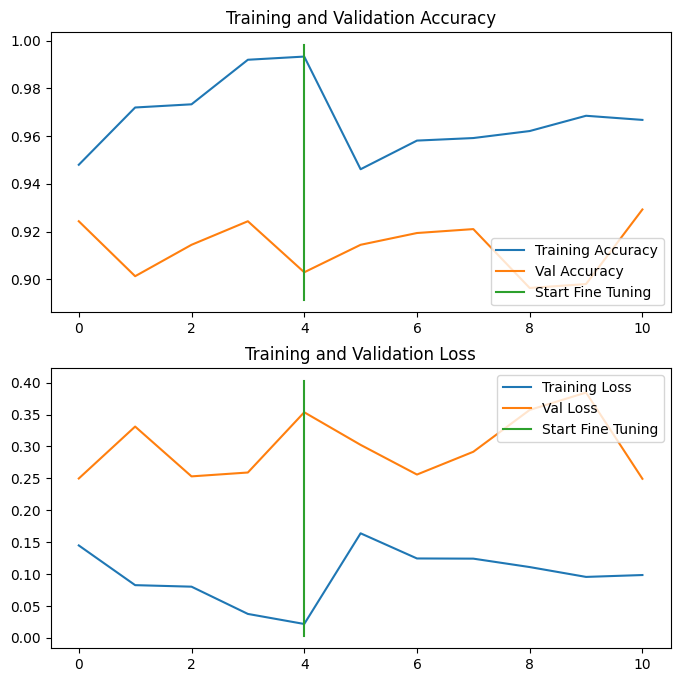

In [ ]:
# How did fine-tuning go with more data
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epoch=5)

## Viewing our experiments data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs on transfer learning experiments (should be ~4 models)
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer Learning Experiments with 10 Food101 Classes" \
 --description "A series of different transfer learning experiments with varying amouts of data and fine-tuning." \
 --one_shot # Exits the uploader 

2023-05-07 13:08:59.950340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MGM-KTR-HWJ



New experiment created. View your TensorBoard at: https://tensorboard.dev/

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/9rQxBSasQiGKxeAsXpLzow/#scalars

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-05-07 13:20:40.923887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/9rQxBSasQiGKxeAsXpLzow/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amouts of data and fine-tuning.
	Id                   9rQxBSasQiGKxeAsXpLzow
	Created              2023-05-07 13:09:23 (11 minutes ago)
	Updated              2023-05-07 13:09:29 (11 minutes ago)
	Runs                 11
	Tags                 5
	Scalars              168
	Tensor bytes         0
	Binary object bytes  5521903
https://tensorboard.dev/experiment/bbajKgWgQYi85OQE5gFZpQ/
	Name                 EfficientNetB0 vs inception_v1
	Description          Comparing two different TF Hub feature extraction model architectures using 10 images
	Id                   bbajKgWgQYi85OQE5gFZpQ
	Created              2023-05-04 08:43:43
	Updated              2

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id fwHeOkKNQL6N9ZepWWgjUw

## 🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
# import our functions from github
!git clone https://github.com/JoachimLombardi/Helper_functions.git
# import helper functions we're going to use in this notebook
from Helper_functions.course_ztm import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

Cloning into 'Helper_functions'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 38 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), 14.56 KiB | 271.00 KiB/s, done.


In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-05-08 06:50:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   153MB/s    in 1.0s    

2023-05-08 06:50:13 (153 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent") 

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
# Create training and test directories paths

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir_10_percent = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
from tensorflow.keras import preprocessing

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# No need to create an image data generator
train_data_10_percent = preprocessing.image_dataset_from_directory(directory = train_dir_10_percent,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = preprocessing.image_dataset_from_directory(directory = test_dir_10_percent,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)  

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [ ]:
from keras.saving.saving_lib import save_weights_only
checkpoint_path='drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt'
def create_checkpoint(checkpoint_path=checkpoint_path):
  # Create a ModelCheckpoint callback that saves the model's weights only
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=False,
                                                          save_freq="epoch", # Save every epoch
                                                          verbose=1)
  return checkpoint_callback

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activations layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                      epochs=10,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[create_tensorboard_callback("drive/MyDrive/10_percent_food/transfer_learning",
                                                             "10_percent_feature_extraction_10_epochs"),
                                 create_checkpoint()])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: drive/MyDrive/10_percent_food/transfer_learning/10_percent_feature_extraction_10_epochs/20230508-065055


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9547 - accuracy: 0.3920
Epoch 1: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt
24/24 [==============================] - 136s 5s/step - loss: 1.9547 - accuracy: 0.3920 - val_loss: 1.3859 - val_accuracy: 0.7220
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.7653
Epoch 2: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt
24/24 [==============================] - 144s 6s/step - loss: 1.1237 - accuracy: 0.7653 - val_loss: 0.9173 - val_accuracy: 0.8207
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.8280
Epoch 3: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt
24/24 [==============================] - 108

In [ ]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,363,770
Non-trainable params: 2,698,611
_________________________________________________________________


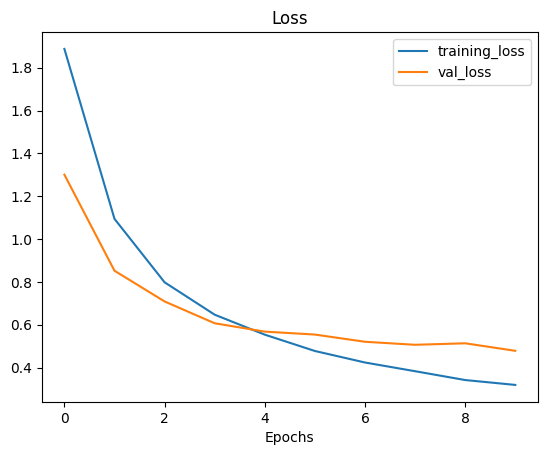

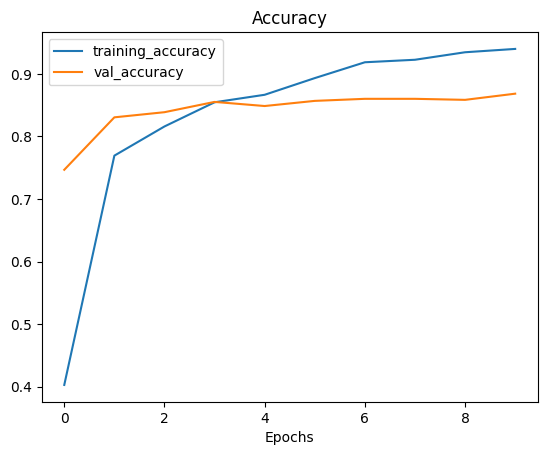

In [ ]:
plot_loss_curves(history_0)

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers until the last 10.
for layer in base_model.layers[:-20]:
  layer.trainable = False

print(len(model_0.layers[1].trainable_variables))

19


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable ?
for i, layer in enumerate(model_0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Recompile (we have to recompile our models every time we make a change)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate for fine-tuning by 10x
                metrics=["accuracy"])

In [ ]:
initial_epoch = 10

In [ ]:
# Continue to train and fit the model to our data  (100% of traing data)
fine_tune_epochs = initial_epoch + 10
history_fine_10_percent_10_epochs = model_0.fit(train_data_10_percent,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.25 * len(test_data)),
                                                initial_epoch=history_0.epoch[-1], 
                                                callbacks=[create_tensorboard_callback(dir_name="drive/MyDrive/10_percent_food/transfer_learning", 
                                                                                       experiment_name="10_percent_fine_tuning_10_epochs")]) #Start training from previous last epoch

Saving TensorBoard log files to: drive/MyDrive/10_percent_food/transfer_learning/10_percent_fine_tuning_10_epochs/20230508-071811
Epoch 10/20
24/24 [==============================] - 142s 6s/step - loss: 0.7659 - accuracy: 0.8133 - val_loss: 0.4288 - val_accuracy: 0.8750
Epoch 11/20
24/24 [==============================] - 149s 6s/step - loss: 0.4789 - accuracy: 0.9187 - val_loss: 0.4282 - val_accuracy: 0.8717
Epoch 12/20
24/24 [==============================] - 113s 5s/step - loss: 0.3548 - accuracy: 0.9373 - val_loss: 0.4272 - val_accuracy: 0.8618
Epoch 13/20
24/24 [==============================] - 113s 5s/step - loss: 0.2797 - accuracy: 0.9600 - val_loss: 0.4029 - val_accuracy: 0.8783
Epoch 14/20
24/24 [==============================] - 148s 6s/step - loss: 0.2205 - accuracy: 0.9747 - val_loss: 0.3761 - val_accuracy: 0.8882
Epoch 15/20
24/24 [==============================] - 147s 6s/step - loss: 0.1824 - accuracy: 0.9787 - val_loss: 0.3831 - val_accuracy: 0.8849
Epoch 16/20
24/24 

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epoch=5):
  """
  Compare two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Plot the two figures
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label="Start Fine Tuning") # x va de 4 à 4 et y se limite aux autres valeurs de y.
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label="Start Fine Tuning") # x va de 4 à 4 et y se limite aux autres valeurs de y.
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

In [ ]:
import matplotlib.pyplot as plt

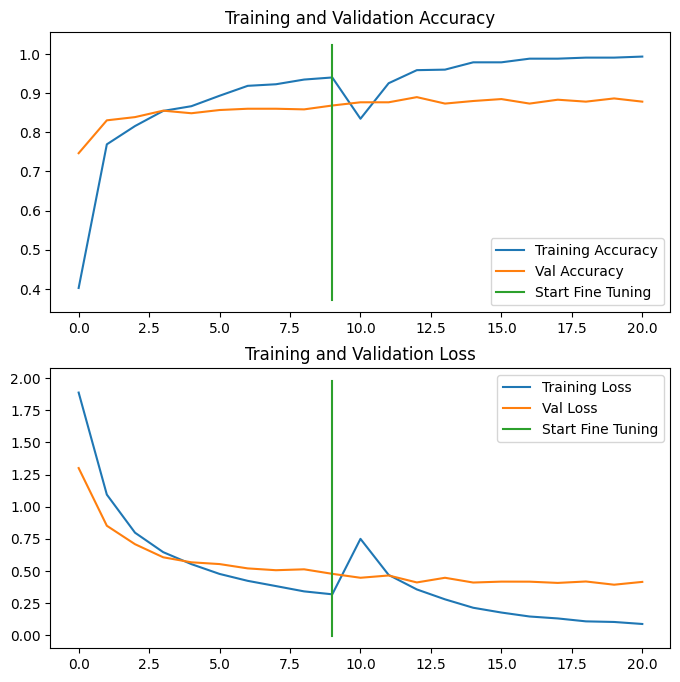

In [ ]:
compare_histories(history_0,
                  history_fine_10_percent_10_epochs,
                  10)

In [ ]:
base_model.trainable = False

In [ ]:
# Recompile (we have to recompile our models every time we make a change)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # lower the learning rate for fine-tuning by 10x
                metrics=["accuracy"])

In [ ]:
# Load in saved model weights 
model_0.load_weights(checkpoint_path)

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers until the last 10.
for layer in base_model.layers[:-30]:
  layer.trainable = False

print(len(model_0.layers[1].trainable_variables))

28


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable ?
for i, layer in enumerate(model_0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Recompile (we have to recompile our models every time we make a change)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate for fine-tuning by 10x
                metrics=["accuracy"])

In [ ]:
# Continue to train and fit the model to our data  
fine_tune_epochs = initial_epoch + 10
history_10_percent_fine_20_unfrozen = model_0.fit(train_data_10_percent,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.25 * len(test_data)),
                                                initial_epoch=history_0.epoch[-1], 
                                                callbacks=[create_tensorboard_callback(dir_name="drive/MyDrive/10_percent_food/transfer_learning", 
                                                                                       experiment_name="10_percent_fine_tuning_20_unfrozen")]) #Start training from previous last epoch

Saving TensorBoard log files to: drive/MyDrive/10_percent_food/transfer_learning/10_percent_fine_tuning_20_unfrozen/20230508-075905
Epoch 10/20
24/24 [==============================] - 167s 7s/step - loss: 0.8407 - accuracy: 0.7907 - val_loss: 0.4212 - val_accuracy: 0.8849
Epoch 11/20
24/24 [==============================] - 149s 6s/step - loss: 0.5283 - accuracy: 0.9040 - val_loss: 0.4036 - val_accuracy: 0.8766
Epoch 12/20
24/24 [==============================] - 149s 6s/step - loss: 0.3781 - accuracy: 0.9413 - val_loss: 0.4140 - val_accuracy: 0.8816
Epoch 13/20
24/24 [==============================] - 151s 6s/step - loss: 0.3080 - accuracy: 0.9560 - val_loss: 0.4290 - val_accuracy: 0.8668
Epoch 14/20
24/24 [==============================] - 151s 6s/step - loss: 0.2428 - accuracy: 0.9707 - val_loss: 0.4046 - val_accuracy: 0.8799
Epoch 15/20
24/24 [==============================] - 151s 6s/step - loss: 0.1947 - accuracy: 0.9773 - val_loss: 0.3930 - val_accuracy: 0.8849
Epoch 16/20
24/2

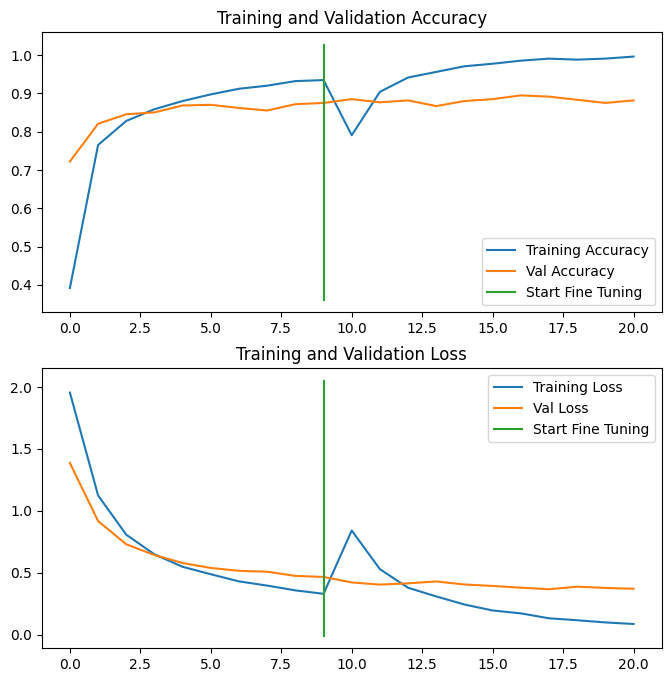

In [ ]:
compare_histories(history_0,
                  history_10_percent_fine_20_unfrozen,
                  10)

With 20 layers unfrozen val accuracy is 0.8816 whereas with 10 layers unfrozen val accuracy is 0.8898. 

## Visualize data

In [ ]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir_10_percent)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
# Let's import visualization function
from Helper_functions.plot_loss_curves import show_batches_images

In [ ]:
# Unbatch train and test data
def unbatchify(dataset):
  images = []
  labels = []
  for image, label in dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_names[np.argmax(label)])
  return images, labels

In [ ]:
# Train data
train_images, train_labels = unbatchify(train_data_10_percent)

In [ ]:
# Test data
test_images, test_labels = unbatchify(test_data)

In [ ]:
train_images[0].shape

(224, 224, 3)

In [ ]:
model_0.predict(tf.expand_dims(train_images[0], axis=0))

1/1 [==============================] - 2s 2s/step


array([[4.2050957e-05, 7.5033605e-03, 9.8782126e-04, 7.1176422e-05,
        6.4844494e-03, 9.7904474e-01, 2.8333525e-05, 2.4680651e-03,
        1.4012883e-03, 1.9686385e-03]], dtype=float32)

In [ ]:
# Make predictions
train_predictions = []
for train_image in train_images:
  train_predictions.append(model_0.predict(tf.expand_dims(train_image, axis=0)))

1/1 [==============================] - 0s 87ms/step


In [ ]:
train_predictions = tf.constant(train_predictions)

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
def show_batches_images_(images, labels, augmented_images=None, augmented_label=None):
  """
  Displays a plot of random images and their labels from a data batch.
  """
  import random
  i = random.choice(range(len(images)))
  j = random.choice(range(len(images)))
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Create subplots (5 rows, 5 columns)
  plt.subplot(1, 2, 1)
  # Display an image
  plt.imshow(images[i])
  print("Showing image number:{}".format(i))
  # Add the image label as the title
  if labels.ndim == 1:
    plt.title(class_names[int(tf.round(labels[i]))])
  else:
    plt.title(class_names[np.argmax(labels[i])])
  # Turn the grid lines off
  plt.axis("off")
  # Create subplots (5 rows, 5 columns)
  plt.subplot(1, 2, 2)
  # Display an image
  plt.imshow(images[j])
  print("Showing image number:{}".format(j))
  # Add the image label as the title
  if labels.ndim == 1:
    plt.title(class_names[int(tf.round(labels[j]))])
  else:
    plt.title(class_names[np.argmax(labels[j])])
  # Turn the grid lines off
  plt.axis("off")
  if (augmented_images is not None):
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Create subplots (5 rows, 5 columns)
    plt.subplot(1, 2, 1)
    # Display an image
    plt.imshow(augmented_images[i])
    print("Showing augmented image number:{}".format(i))
    # Add the image label as the title
    if labels.ndim == 1:
      plt.title(class_names[int(tf.round(augmented_labels[i]))])
    else:
      plt.title(class_names[np.argmax(augmented_labels[i])])
      # Turn the grid lines off
      plt.axis("off")
      # Create subplots (5 rows, 5 columns)
      plt.subplot(1, 2, 2)
      # Display an image
      plt.imshow(augmented_images[j])
      print("Showing augmented image number:{}".format(j))
      # Add the image label as the title
    if labels.ndim == 1:
      plt.title(class_names[int(tf.round(augmented_labels[j]))])
    else:
      plt.title(class_names[np.argmax(augmented_labels[j])])
      # Turn the grid lines off
      plt.axis("off")
      

In [ ]:
train_images = tf.constant(train_images)

In [ ]:
train_images = train_images / 255.

Showing image number:444
Showing image number:316


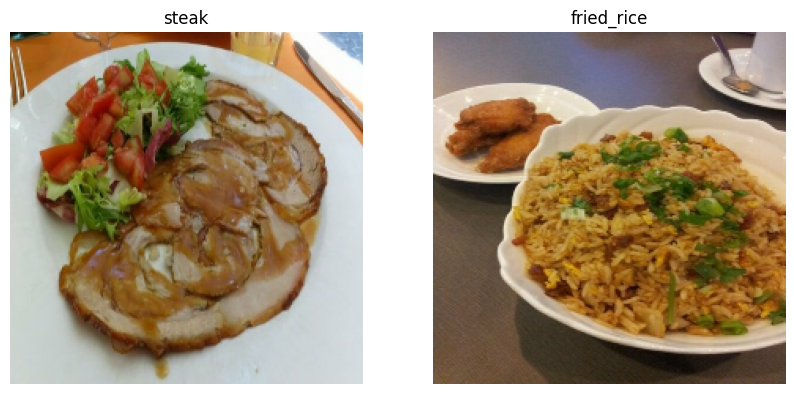

In [ ]:
show_batches_images_(train_images, train_predictions)

In [ ]:
# Make predictions
test_predictions = []
for test_image in test_images:
  test_predictions.append(model_0.predict(tf.expand_dims(test_image, axis=0)))

1/1 [==============================] - 0s 95ms/step


In [ ]:
test_predictions = tf.constant(test_predictions)
test_images = tf.constant(test_images)/255.

Showing image number:476
Showing image number:1119


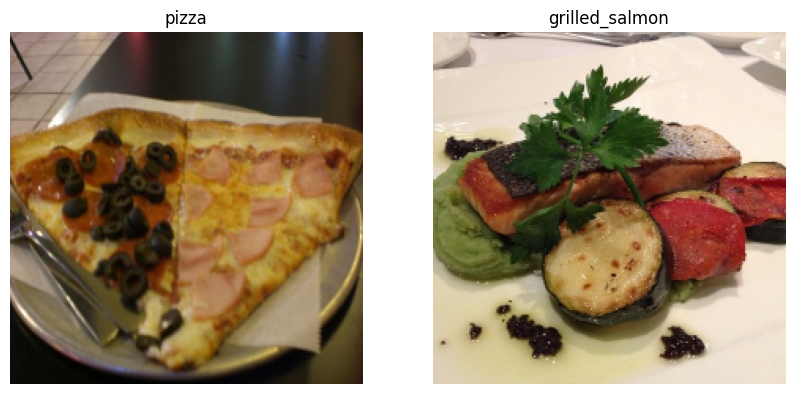

In [ ]:
show_batches_images_(test_images, test_predictions)

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

# 🏃‍♀️ Quickstart
Use **[Weights & Biases](https://wandb.ai/site?utm_source=intro_colab&utm_medium=code&utm_campaign=intro)** for machine learning experiment tracking, model checkpointing, and collaboration with your team. See the full Weights & Biases Documentation **[here](https://docs.wandb.ai/guides/integrations/keras)**

## 🪄 Install `wandb` library and login


Start by installing the library and logging in to your free account.


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## 👟 Run an experiment
1️⃣. **Start a new run** and pass in hyperparameters to track

2️⃣. **Log metrics** from training or evaluation

3️⃣. **Visualize results** in the dashboard

In [ ]:
import random

# Launch 5 simulated experiments
total_runs = 5
for run in range(total_runs):
  # 🐝 1️⃣ Start a new run to track this script
  wandb.init(
      # Set the project where this run will be logged
      project="basic-intro", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{run}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.02,
      "architecture": "CNN",
      "dataset": "CIFAR-100",
      "epochs": 10,
      })
  
  # This simple block simulates a training loop logging metrics
  epochs = 10
  offset = random.random() / 5
  for epoch in range(2, epochs):
      acc = 1 - 2 ** -epoch - random.random() / epoch - offset
      loss = 2 ** -epoch + random.random() / epoch + offset
      
      # 🐝 2️⃣ Log metrics from your script to W&B
      wandb.log({"acc": acc, "loss": loss})
      
  # Mark the run as finished
  wandb.finish()

wandb: Currently logged in as: lombardi-joachim (deep-lea). Use `wandb login --relogin` to force relogin


acc,▁▃█▆▇█▇█
loss,█▄▃▃▂▃▁▁
acc,0.76026
loss,0.19521


acc,▁▃▅▆▇██▇
loss,█▃▄▄▂▁▂▁
acc,0.70925
loss,0.23206


acc,▁▄▇▆█▇█▇
loss,█▆▅▂▂▁▄▃
acc,0.80226
loss,0.20333


acc,▁▃▆▇▄▆██
loss,█▂▄▂▂▁▁▂
acc,0.9503
loss,0.11205


acc,▁▆▇▇▇█▇▇
loss,▆█▃▃▂▁▂▂
acc,0.74384
loss,0.22781


In [ ]:
# Try with efficientNetB4

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB4(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activations layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# 10. Fit the model and save its history
history_1 = model_1.fit(train_data_10_percent,
                      epochs=10,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[create_tensorboard_callback("drive/MyDrive/10_percent_food/transfer_learning",
                                                             "10_percent_feature_extraction_10_epochs"),
                                 create_checkpoint()])

71686520/71686520 [==============================] - 1s 0us/step
Saving TensorBoard log files to: drive/MyDrive/10_percent_food/transfer_learning/10_percent_feature_extraction_10_epochs/20230508-112608


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.6858 - accuracy: 0.5360
Epoch 1: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt
24/24 [==============================] - 332s 13s/step - loss: 1.6858 - accuracy: 0.5360 - val_loss: 1.0921 - val_accuracy: 0.7730
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.7747
Epoch 2: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt
24/24 [==============================] - 305s 13s/step - loss: 0.9656 - accuracy: 0.7747 - val_loss: 0.7510 - val_accuracy: 0.8174
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.8240
Epoch 3: saving model to drive/MyDrive/10_percent_food/ten_percent_model_checkpoints_weights/checkpoint_10_epochs_feature_extraction.ckpt
24/24 [==============================] - 3

### 📖 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Extra-curriculum

* Read the [documentation on data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) in TensorFlow.
* Read the [ULMFit paper](https://arxiv.org/abs/1801.06146) (technical) for an introduction to the concept of freezing and unfreezing different layers.
* Read up on learning rate scheduling (there's a [TensorFlow callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) for this), how could this influence our model training?
  * If you're training for longer, you probably want to reduce the learning rate as you go... the closer you get to the bottom of the hill, the smaller steps you want to take. Imagine it like finding a coin at the bottom of your couch. In the beginning your arm movements are going to be large and the closer you get, the smaller your movements become.